# Viral Data Analysis

Date: 2020.10.26

Author: © 2020 Grantas Gadliauskas

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [What is the average % of people who wear mask in public places for each continent today?](#Q1)
1. [What is the correlation between a country having a mask-wearing culture history and amount of COVID-19 cases?](#Q2)
1. [What are the predictions of COVID-19 cases for countries which started wearing masks versus countries which did not adopt mask wearing?](#Q3)

We additionally use data from:
* https://today.yougov.com/topics/international/articles-reports/2020/03/17/personal-measures-taken-avoid-covid-19 (YouGov COVID-19 behaviour changes tracker: Wearing a face mask when in public places:
% of people in each market who say they are: Wearing a face mask when in public places)

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [230]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [231]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

11654465

Load the file to Pandas.

In [232]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3]).fillna(0)

Check the columns available.

In [233]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

Loading other data: % of people in each market who say they are: Wearing a face mask when in public places.

In [234]:
fname = 'mask-data.csv'
url = 'https://drive.google.com/uc?export=download&id=1-M8qZjzP4MENDF8OiwkMmmgoDnEu6jkl'
r = requests.get(url)
open(fname, 'wb').write(r.content)

7878

Load file to pandas.

In [235]:
url = "mask-data.csv" 
df_masks = pd.read_csv(url, parse_dates=[0])

Rename country abbreviations to full country names to uniform country naming between data frames.

In [236]:
df_masks = df_masks.rename(columns={"UAE": "United Arab Emirates", "UK": "United Kingdom", "USA": "United States"})

Check the data to verify that it loaded successfully.


In [237]:
df_masks.head()

,DateTime,Australia,Canada,China,Denmark,Finland,France,Germany,Hong Kong,India,Indonesia,Italy,Japan,Malaysia,Mexico,Norway,Philippines,Saudi Arabia,Singapore,Spain,Sweden,Taiwan,Thailand,United Arab Emirates,United Kingdom,United States,Vietnam
0,2020-02-21 23:51:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-24 23:51:40,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN,55.0,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN
2,2020-02-25 23:51:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN
3,2020-02-28 23:51:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-01 23:51:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


<a id='Q1'></a>
## 1. What is the average % of people who wear mask in public places for each continent today? 

First, we merge the two loaded data frames in to a single data frame which contains just enough information to answer the question. To get the most recent data, for each country we only take the latest existing record from the masks dataset.




In [238]:
dfPercentageByCountryContinent = pd.DataFrame(columns=['country', 'continent', 'mask_wearing_percentage_today'])
for col_name, data in df_masks.items(): 
  if col_name != 'DateTime':
    percentage = data.iloc[data.last_valid_index()]
    continent = df[df['location'] == col_name]['continent'].iloc[0]
    dfPercentageByCountryContinent = dfPercentageByCountryContinent.append({'country': col_name, 'continent': continent, 'mask_wearing_percentage_today': percentage}, ignore_index=True)

dfPercentageByCountryContinent

,country,continent,mask_wearing_percentage_today
0,Australia,Oceania,48.0
1,Canada,North America,80.0
2,China,Asia,82.0
3,Denmark,Europe,40.0
4,Finland,Europe,46.0
5,France,Europe,81.0
6,Germany,Europe,64.0
7,Hong Kong,Asia,88.0
8,India,Asia,79.0
9,Indonesia,Asia,84.0


Then, we group rows by continent and display their percentage averages.

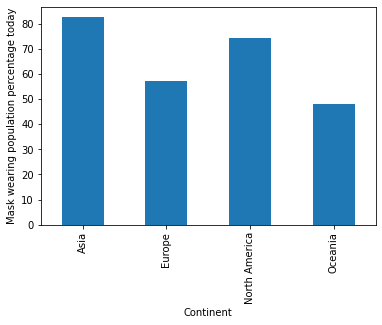

In [239]:
means = dfPercentageByCountryContinent.groupby('continent').mean()
means.plot.bar(xlabel='Continent', ylabel='Mask wearing population percentage today', legend=0)

As we can see from the chart, the continents of Europe and Oceania report substantially lower percentages. This means, that as of October 2020, people in Europe and Oceania tend to wear masks in public places slightly less often compared to the other continents.

<a id='Q2'></a>
## 2. What is the correlation between a country having a mask-wearing culture history and amount of COVID-19 cases? 

Let's make an assumption that a country that has a long living mask-wearing culture should have more people wearing masks at the start of the pandemic than a country without such a culture. Let's check this assumption by checking the earliest recorded mask-wearing percentage for each country.

In [240]:
dfPercentageByCountry = pd.DataFrame(columns=['location', 'mask_wearing_percentage_at_start_of_pandemic'])
for col_name, data in df_masks.items(): 
  if col_name != 'DateTime':
    percentage = data.iloc[data.first_valid_index()]
    dfPercentageByCountry = dfPercentageByCountry.append({'location': col_name, 'mask_wearing_percentage_at_start_of_pandemic': percentage}, ignore_index=True)

dfPercentageByCountry

,location,mask_wearing_percentage_at_start_of_pandemic
0,Australia,10.0
1,Canada,6.0
2,China,85.0
3,Denmark,1.0
4,Finland,1.0
5,France,5.0
6,Germany,2.0
7,Hong Kong,90.0
8,India,43.0
9,Indonesia,54.0


Let's sort the data by the percentage

In [241]:
dfPercentageByCountry.sort_values('mask_wearing_percentage_at_start_of_pandemic', ascending=False).head(10)

,location,mask_wearing_percentage_at_start_of_pandemic
7,Hong Kong,90.0
2,China,85.0
20,Taiwan,84.0
21,Thailand,73.0
15,Philippines,62.0
11,Japan,62.0
25,Vietnam,59.0
12,Malaysia,55.0
9,Indonesia,54.0
8,India,43.0


As we can see, Asian countries that are known for their mask-wearing cultures were better prepared with masks during the start of the pandemic. Let's check how does that correlate to total COVID-19 cases per million residents. First, let's filter the latest data for each country from the OWID COVID dataset.

In [242]:
dfLatest = df.groupby('iso_code').last()
dfLatest.head()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,International,2020-10-27,696.0,0.0,0.000,7.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,0.00,0.000
ABW,North America,Aruba,2020-10-27,4420.0,0.0,12.286,36.0,0.0,0.286,41398.947,0.000,115.071,337.186,0.000,2.676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,106766.0,584.800,41.2,13.085,7.452,35973.781,0.0,0.000,11.62,0.0,0.0,0.000,0.0,76.29,0.000
AFG,Asia,Afghanistan,2020-10-27,41032.0,199.0,106.429,1522.0,8.0,3.571,1054.039,5.112,2.734,39.097,0.206,0.092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
AGO,Africa,Angola,2020-10-27,9381.0,355.0,251.286,268.0,1.0,3.000,285.429,10.801,7.646,8.154,0.030,0.091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,32866268.0,23.890,16.8,2.405,1.362,5819.495,0.0,276.045,3.94,0.0,0.0,26.664,0.0,61.15,0.581
AIA,North America,Anguilla,2020-10-27,3.0,0.0,0.000,0.0,0.0,0.000,199.973,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,15002.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.000,0.0,81.88,0.000


Let's join the aforementioned datasets and examine the correlation between the mask-wearing population percentage at the start of the pandemic and COVID related data.

In [243]:
pd.merge(dfPercentageByCountry, dfLatest, on='location').corr()[["mask_wearing_percentage_at_start_of_pandemic"]]

,mask_wearing_percentage_at_start_of_pandemic
mask_wearing_percentage_at_start_of_pandemic,1.000000
total_cases,-0.146223
new_cases,-0.352903
new_cases_smoothed,-0.295813
total_deaths,-0.248976
new_deaths,-0.252437
new_deaths_smoothed,-0.222822
total_cases_per_million,-0.588489
new_cases_per_million,-0.443488
new_cases_smoothed_per_million,-0.523188


As we can see, mask wearing population percentage at the start of the pandemic has a strong inverse correlation with total COVID-19 cases per million and total COVID-19 deaths per million. (-0.566792 and -0.565439) accordingly. In other words, a citizen from a country with a strong mask-wearing culture has a much lower chance to get COVID than a citizen from a country without one.

<a id='Q3'></a>
## 3. What are the predictions of COVID-19 cases for countries which started wearing masks versus countries which did not adopt mask wearing?

To answer this question, we will apply linear regression on the "New cases per million residents" feature of the COVID-19 dataset from July until now to predict the number of new cases in December 2020.

First, we define a function that will plot the current data and the predicted value for a selected country.

In [244]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def plotCovidCasePrediction(countryName, color):
  df_country = df[df['location'] == countryName][-115:]
  df_country_x = np.arange(df_country.shape[0])
  df_country_y = df_country['new_cases_smoothed_per_million'].to_numpy()
  df_country_x_prediction = np.arange(df_country.shape[0]+30)

  regr = LinearRegression()
  df_country_x = df_country_x.reshape(-1, 1)
  df_country_x_prediction = df_country_x_prediction.reshape(-1, 1)

  regr.fit(df_country_x, df_country_y)
  df_country_y_prediction = regr.predict(df_country_x_prediction)

  plt.plot(df_country_x, df_country_y, color=color, linewidth=3, label=countryName)
  plt.plot(df_country_x_prediction, df_country_y_prediction,  color=color, linestyle='dashed')


Then, we will use the mask dataset to get the earliest mask wearing percentage record since the start of July for each country.

In [245]:
dfPercentageByCountryAtJuly = pd.DataFrame(columns=['location', 'mask_wearing_percentage_at_july'])
for col_name, data in df_masks[-75:].reset_index().items(): 
  if col_name not in ['DateTime', 'index'] and data.first_valid_index() != None:
    percentage = data.iloc[data.first_valid_index()]
    dfPercentageByCountryAtJuly = dfPercentageByCountryAtJuly.append({'location': col_name, 'mask_wearing_percentage_at_july': percentage}, ignore_index=True)

dfPercentageByCountryAtJuly

,location,mask_wearing_percentage_at_july
0,Australia,20.0
1,Canada,60.0
2,China,82.0
3,Denmark,34.0
4,Finland,21.0
5,France,79.0
6,Germany,65.0
7,Hong Kong,86.0
8,India,82.0
9,Indonesia,85.0


Now, we want to know which countries have started wearing masks and which did not. We will dismiss countries that already had worn masks at the start of the pandemic (mask wearing percentage at the start of the pandemic should be lower than 50%). 

In [246]:
dfPercentageByNonMaskWearingCultureCountry = dfPercentageByCountry[dfPercentageByCountry['mask_wearing_percentage_at_start_of_pandemic'] < 50]
merged = pd.merge(dfPercentageByNonMaskWearingCultureCountry, dfPercentageByCountryAtJuly, on='location')
merged['increase_in_mask_wearing'] = merged['mask_wearing_percentage_at_july'] - merged['mask_wearing_percentage_at_start_of_pandemic']
merged.sort_values('increase_in_mask_wearing', ascending=False)

,location,mask_wearing_percentage_at_start_of_pandemic,mask_wearing_percentage_at_july,increase_in_mask_wearing
11,Spain,5.0,88.0,83.0
4,France,5.0,79.0,74.0
10,Singapore,24.0,90.0,66.0
15,United States,7.0,73.0,66.0
5,Germany,2.0,65.0,63.0
7,Italy,26.0,83.0,57.0
1,Canada,6.0,60.0,54.0
9,Saudi Arabia,35.0,75.0,40.0
13,United Arab Emirates,39.0,79.0,40.0
6,India,43.0,82.0,39.0


We will pick 5 countries with the biggest increase in mask wearing.

In [247]:
countriesThatStartedWearingMasks = merged.sort_values('increase_in_mask_wearing', ascending=False)[:5]

Let's plot the predictions. Dots on the right side of the graph denote the expected number of new COVID-19 cases for million residents in 
December 2020.

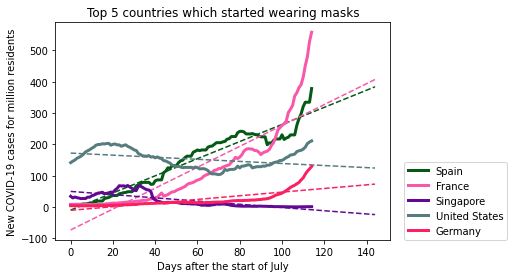

In [248]:
for idx, data in countriesThatStartedWearingMasks.iterrows():
  plotCovidCasePrediction(data['location'], np.random.rand(3,))

plt.title("Top 5 countries which started wearing masks")
plt.ylabel("New COVID-19 cases for million residents")
plt.xlabel("Days after the start of July")
plt.legend(loc=(1.04,0))
plt.show()

Let's do the same for the 5 countries with the least amount of increase in mask wearing.

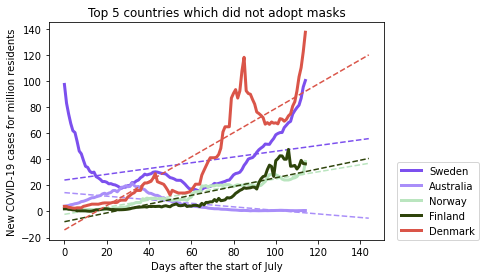

In [249]:
countriesThatDidNotAdaptMasks = merged.sort_values('increase_in_mask_wearing', ascending=True)[:5]
for idx, data in countriesThatDidNotAdaptMasks.iterrows():
  plotCovidCasePrediction(data['location'], np.random.rand(3,))

plt.title("Top 5 countries which did not adopt masks")
plt.ylabel("New COVID-19 cases for million residents")
plt.xlabel("Days after the start of July")
plt.legend(loc=(1.04,0))
plt.show()

As we can see, the countries that started wearing the most masks have a higher expected new case count than countries that did not adopt masks. In conclusion, countries which started wearing masks do not perform better than countries which did not start wearing masks as far as prevention of new COVID-19 cases are concerned.

Does wearing masks consistently from the start of the pandemic until now help? Let's check.

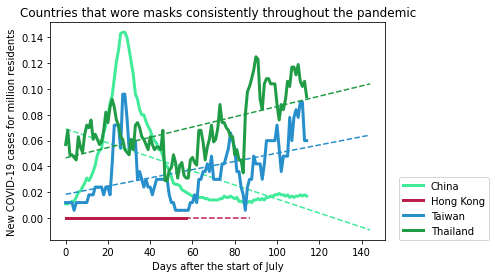

In [250]:
merged = pd.merge(dfPercentageByCountry, dfPercentageByCountryAtJuly, on='location')
countriesThatWoreMasksConsistently = merged[(merged['mask_wearing_percentage_at_start_of_pandemic'] > 70) & (merged['mask_wearing_percentage_at_july'] > 70)]

for idx, data in countriesThatWoreMasksConsistently.iterrows():
  plotCovidCasePrediction(data['location'], np.random.rand(3,))

plt.title("Countries that wore masks consistently throughout the pandemic")
plt.ylabel("New COVID-19 cases for million residents")
plt.xlabel("Days after the start of July")
plt.legend(loc=(1.04,0))
plt.show()

Indeed, countries that wore masks consistently throughout the pandemic are expected to have close to zero new cases in December 2020.